In [1]:
%load_ext autoreload

import numpy as np
import matplotlib.pyplot as plt
import jax as jx
import jax.numpy as jnp
from jax.example_libraries import optimizers
from functools import partial

from tqdm import tqdm

In [2]:
%cd /mnt/c/Users/efrai/Documentos/IDEAS/WORKSHOP/Improving_initialization/

/mnt/c/Users/efrai/Documentos/IDEAS/WORKSHOP/Improving_initialization


/home/emmt/anaconda3/envs/workshop/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [3]:
%autoreload 
from code_lib.Forward import *
from code_lib.Training import *

In [4]:
def init_params(layers, key):
  # Glorot initialization
  Ws = []
  bs = []
  for i in range(len(layers) - 1):
    std_glorot = jnp.sqrt(2/(layers[i] + layers[i + 1]))
    key, subkey = jx.random.split(key)
    Ws.append(jx.random.normal(subkey, (layers[i], layers[i + 1]))*std_glorot)
    bs.append(jnp.zeros(layers[i + 1]))    
    # key, subkey = jx.random.split(key)
    # bs.append(jx.random.normal(subkey, (layers[i + 1],))*std_glorot)
  return [Ws, bs]

def init_params(layers, key):
  # Equisdi initialization
  Ws = []
  bs = []
  for i in range(len(layers) - 1):
    c = jnp.linspace(-1, 1, layers[i + 1]+2)[1:-1]
    W = np.ones((layers[i], layers[i + 1]))
    W[::2,::2]*=-1

    Ws.append(W)  
    bs.append(-W[0]*c)
  return [Ws, bs]

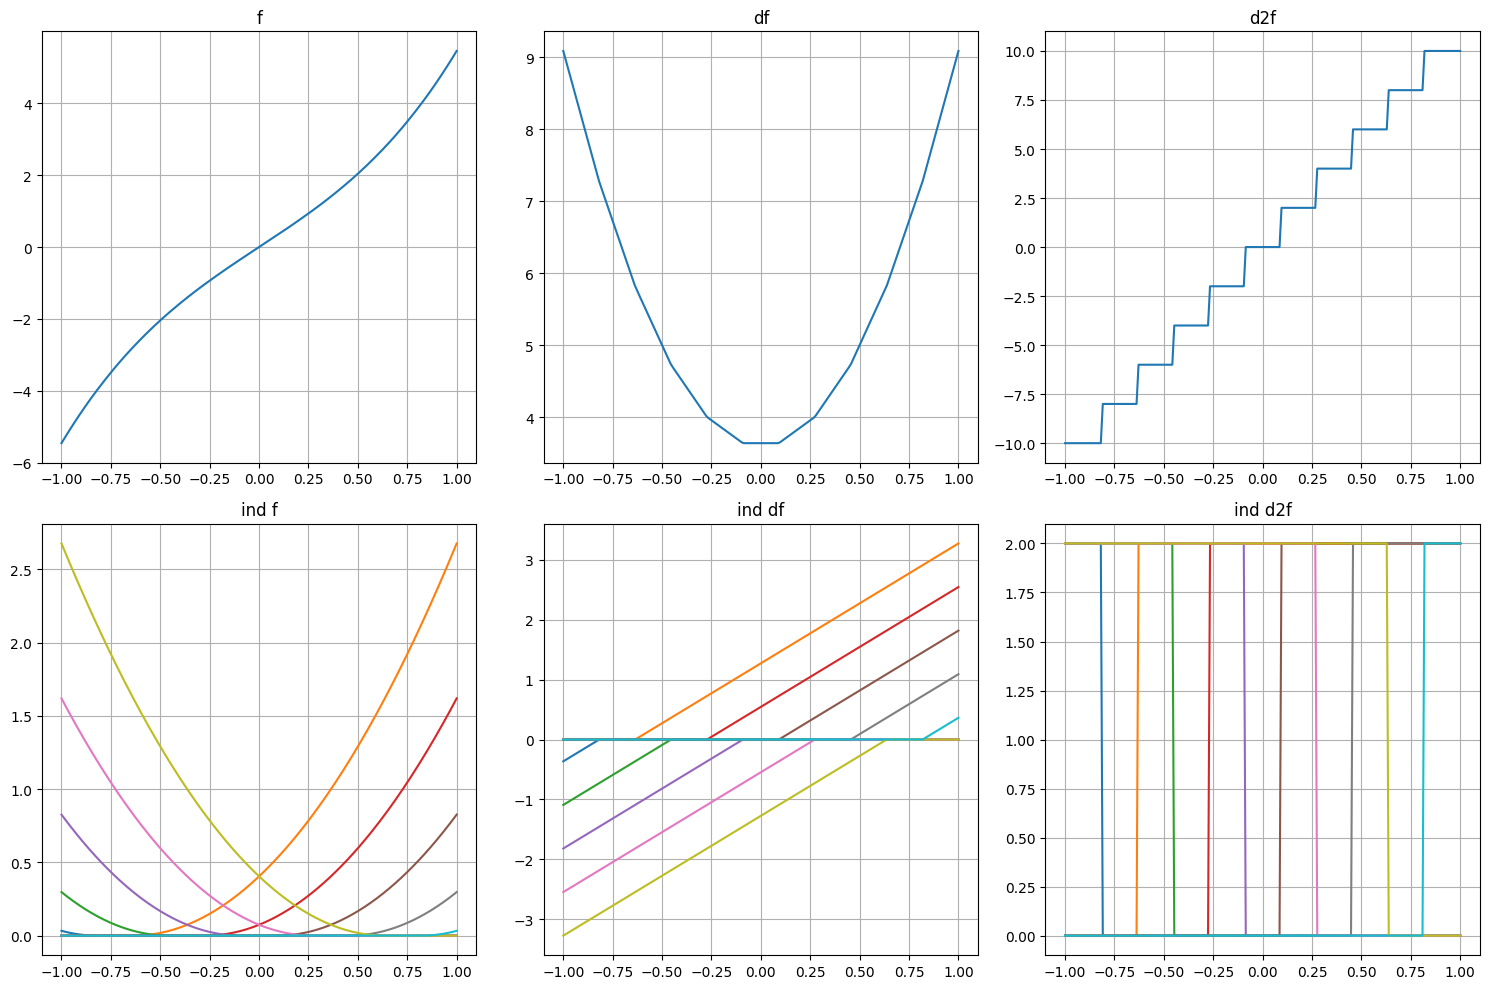

In [5]:
layers = [1] + [10]*1 + [1]
key = jx.random.PRNGKey(0)

params = init_params(layers, key)

X = np.linspace(-1, 1, 200)[:, None]
fig = plt.figure(figsize=(15, 10))
ax = fig.subplots(2,3)
ax[0,0].plot(X, forward_pass(X, params), label="f")
ax[0,1].plot(X, forward_grad_pass(X, params), label="f")
ax[0,2].plot(X, forward_grad2_pass(X, params), label="f")
ax[0,0].set_title("f")
ax[0,1].set_title("df")
ax[0,2].set_title("d2f")
ax[1,0].plot(X, one_pass(X, params), label="f")
ax[1,1].plot(X, one_grad_pass(X, params), label="f")
ax[1,2].plot(X, one_grad2_pass(X, params), label="f")
ax[1,0].set_title("ind f")
ax[1,1].set_title("ind df")
ax[1,2].set_title("ind d2f")
for a in ax.flatten(): a.grid()
fig.tight_layout()
plt.show()

(200, 10) (200, 1)
(200, 10, 1) (200, 1, 1)
(200, 10, 1, 1) (200, 1, 1, 1)


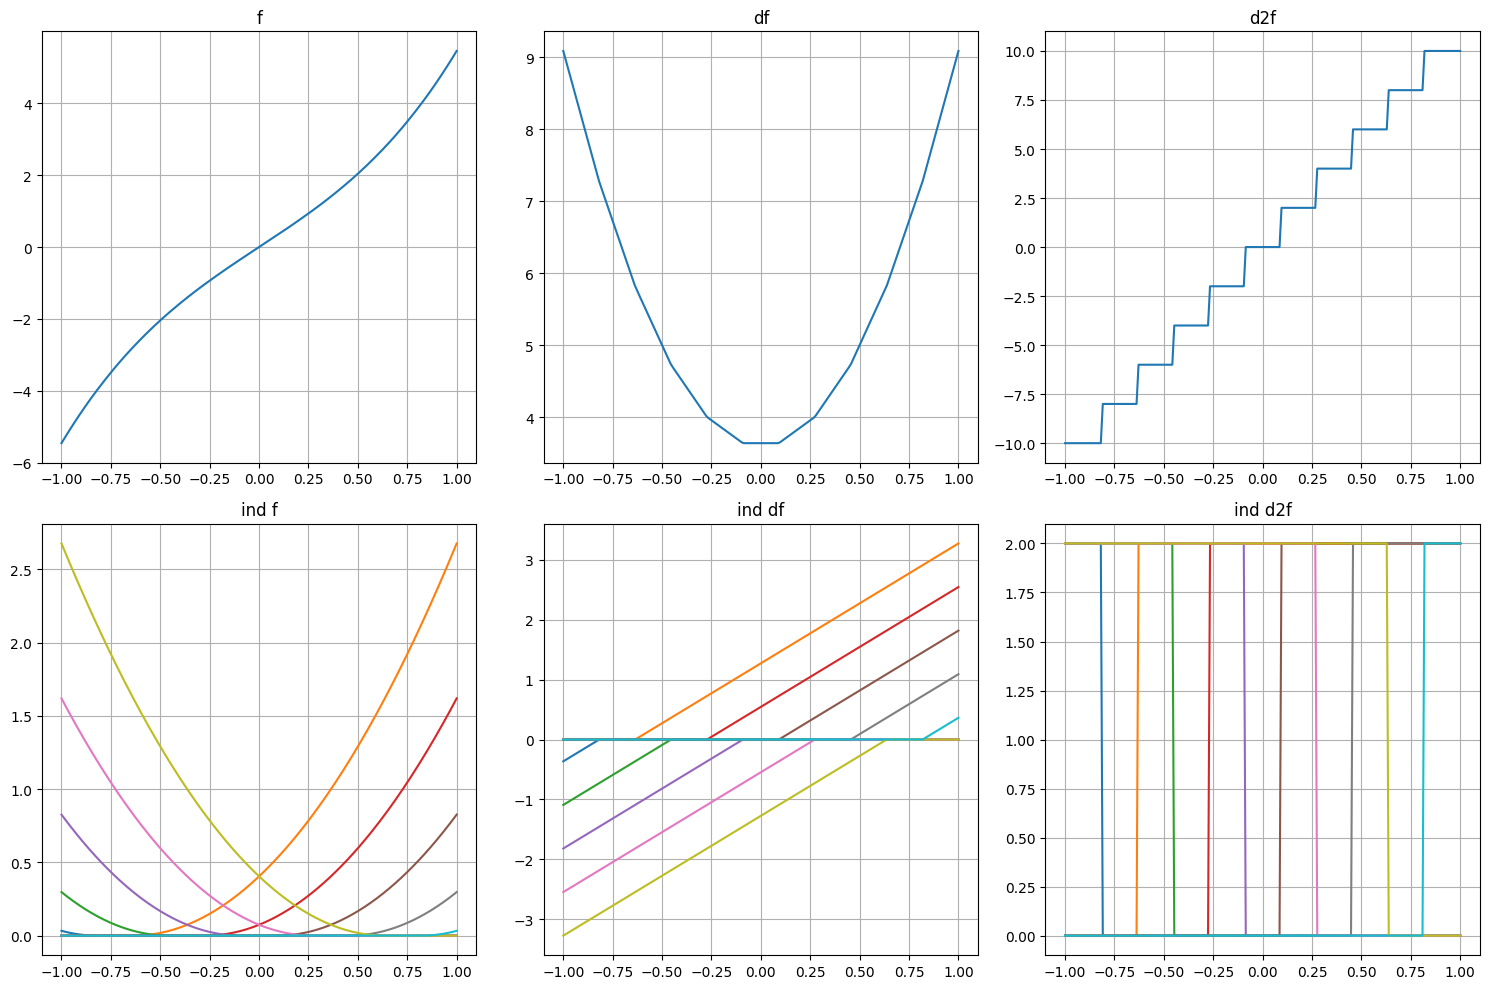

In [6]:
fig = plt.figure(figsize=(15, 10))
ax = fig.subplots(2,3)
L, Y = forward_pass_multi(X, params, params[0][-1])
print(L.shape, Y.shape)
ax[0,0].plot(X, Y)
ax[1,0].plot(X, L)
L, Y = forward_pass_multi_grad(X, params, params[0][-1])
print(L.shape, Y.shape)
ax[0,1].plot(X, Y[...,0])
ax[1,1].plot(X, L[...,0])
L, Y = forward_pass_multi_grad2(X, params, params[0][-1])
print(L.shape, Y.shape)
ax[0,2].plot(X, Y[...,0,0])
ax[1,2].plot(X, L[...,0,0])
ax[0,0].set_title("f")
ax[0,1].set_title("df")
ax[0,2].set_title("d2f")
ax[1,0].set_title("ind f")
ax[1,1].set_title("ind df")
ax[1,2].set_title("ind d2f")
for a in ax.flatten(): a.grid()
fig.tight_layout()
plt.show()

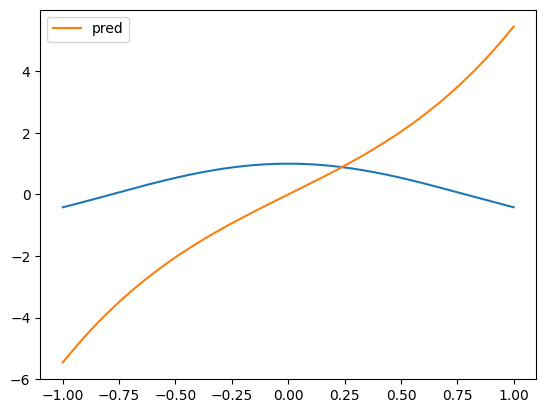

Array(7.9233713, dtype=float32)

In [7]:
@jx.jit
def loss(params, s, X, Y, X_c):
    _, Y_pred = forward_pass_multi(X, params, s)
    MSE = jnp.mean((Y_pred-Y)**2)
    return MSE
X_c = jnp.array([[-1,1]]).T
X = jnp.linspace(-1,1, 2000)[:, None]
Y = jnp.cos(2*X)
rng_agent = np.random.default_rng(6516)
train_samples = rng_agent.choice(X.shape[0], 256)
X_train = X[train_samples]
Y_train = Y[train_samples]
plt.plot(X, Y)
L, Y_pred = forward_pass_multi(X, params, params[0][-1])
plt.plot(X, Y_pred, label="pred")
plt.legend()
plt.show()
s0 = params[0][-1]
loss(params, s0, X, Y, X_c)

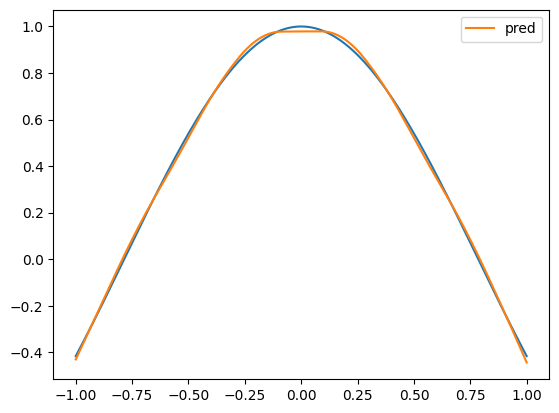

Array(0.00016871, dtype=float32)

In [8]:
@partial(jx.jit, static_argnums=(0,))
def leastsquares(loss, params, s, X, Y, X_c):
    gl = jx.grad(loss, argnums=1)
    B = gl(params, s*0, X, Y, X_c)
    A = 0.5*jx.jacfwd(gl, argnums=1)(params, s*0, X, Y, X_c).squeeze()
    return -0.5*jnp.linalg.pinv(A)@B

s = leastsquares(loss, params, s0, X_train, Y_train, X_c)
plt.plot(X, Y)
L, Y_pred = forward_pass_multi(X, params, s)
plt.plot(X, Y_pred, label="pred")
plt.legend()
plt.show()
loss(params, s, X, Y, X_c)

it 950, train loss = 2.204243e-01: 100%|████████████████████████████████████████████| 1000/1000 [00:42<00:00, 23.67it/s]


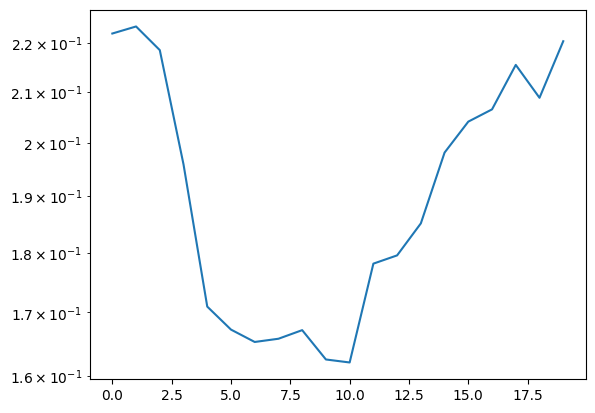

In [9]:
layers = [1] + [32]*1 + [1]
bsize = 512*2
nIter = 1000
lr = 1e-4
stop_at = 1e-20
X = jnp.linspace(-1,1, 10000)[:, None]
Y = np.cos(X*2*np.pi)-1
dY = -2*np.pi*np.sin(X*2*np.pi)
d2Y = -4*np.pi**2*np.cos(X*2*np.pi)

trainer = Training2(optimizers.adam, {"lr":lr}, mode="MC")

key = jx.random.PRNGKey(0)

X_c = jnp.array([[-1,1]]).T
lmbi = 1e-2
@jx.jit
def loss(params, s, X, Y, X_c):
    _, Y_pred = forward_pass_multi(X_c, params, s)
    # _, Y_pred_g = forward_pass_multi_grad(X, params, s)
    _, Y_pred_g2 = forward_pass_multi_grad2(X, params, s)
    obj = -4*jnp.pi**2*jnp.cos(X*2*jnp.pi)#*0+1
    MSE =jnp.mean((Y_pred_g2.squeeze()-obj.squeeze())**2)*lmbi
    MSE+= jnp.mean(Y_pred**2)
    return MSE
params = init_params(layers, key)
opt_state = trainer.opt_init(params)
params, train_loss, val_loss = trainer.train(loss, 
        X_train, Y_train, X_c, opt_state, bsize=bsize, nIter = nIter, stop=stop_at)
plt.semilogy(train_loss)
plt.show()

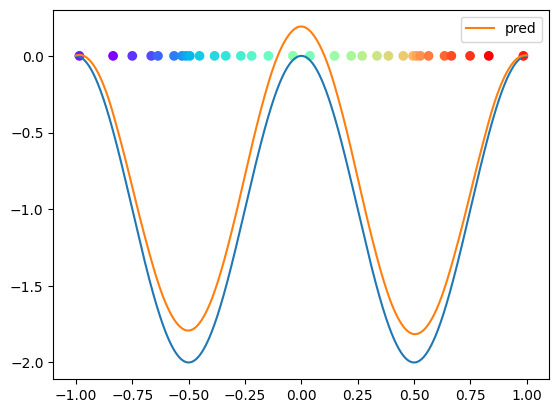

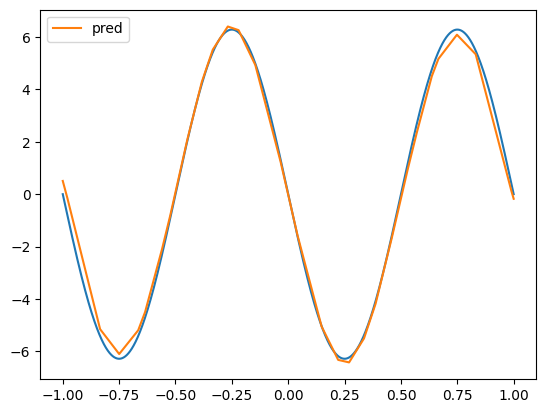

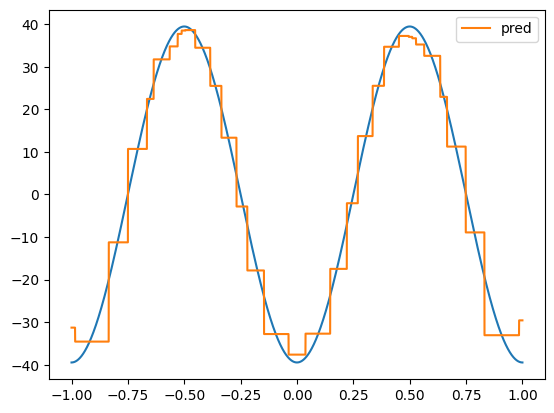

In [10]:
W0, b0 = params
W0 = W0[0]
b0 = b0[0]
plt.plot(X, Y)
plt.scatter(-b0/W0[0], [0]*b0.shape[0], c=np.linspace(0, 1, b0.shape[0]), cmap="rainbow")
L, Y_pred = forward_pass_multi(X, params, params[0][-1])
plt.plot(X, Y_pred, label="pred")
plt.legend()
plt.show()
plt.plot(X, dY)
L, Y_pred = forward_pass_multi_grad(X, params, params[0][-1])
plt.plot(X, Y_pred.squeeze(), label="pred")
plt.legend()
plt.show()
plt.plot(X, d2Y)
L, Y_pred = forward_pass_multi_grad2(X, params, params[0][-1])
plt.plot(X, Y_pred.squeeze(), label="pred")
plt.legend()
plt.show()

(40000, 2) (40000, 1)


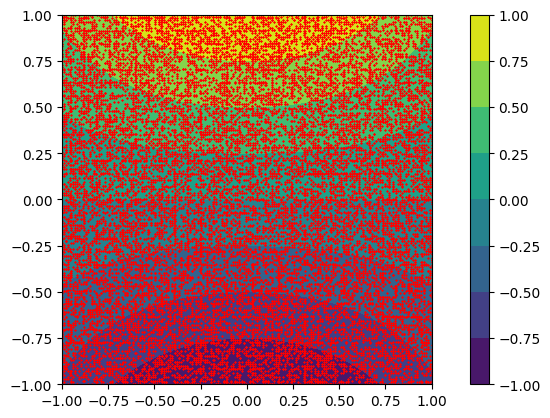

In [11]:
x = np.linspace(-1, 1, 200)
mesh = np.meshgrid(x, x)
X = np.c_[mesh[0].flatten(), mesh[1].flatten()]
Y = np.cos(np.pi*X[:,0])*np.cos(np.pi*X[:,1])
Y = np.cos(X[:,0])*X[:,1]
# Y = (X[:,0]**2+X[:,1]**2)[:,None]
Y = Y[:,None]
dYx = -np.sin(X[:,0])*X[:,1]
dYy = np.cos(X[:,0])
d2Yxx = -np.cos(X[:,0])*X[:,1]
d2Yxy = -np.sin(X[:,0])
d2Yyy = 0*X[:,0]
d2Yyx = -np.sin(X[:,0])

print(X.shape, Y.shape)

# Y = jx.nn.relu(X*0.2+0.2)**3
rng_agent = np.random.default_rng(6516)
train_samples = rng_agent.choice(X.shape[0], 20000)
X_train = X[train_samples]
Y_train = Y[train_samples]

plt.contourf(*mesh, Y.reshape(mesh[0].shape))
plt.plot(X_train[:,0], X_train[:,1], "rx", ms=1)
plt.colorbar()
plt.axis("scaled")
plt.show()

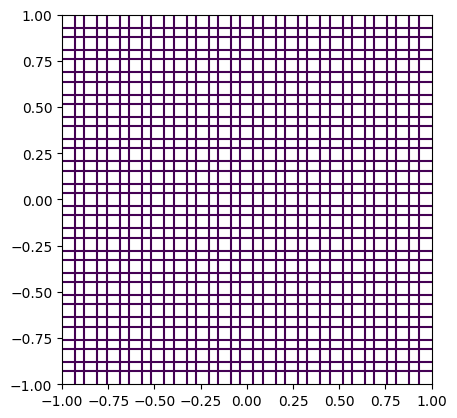

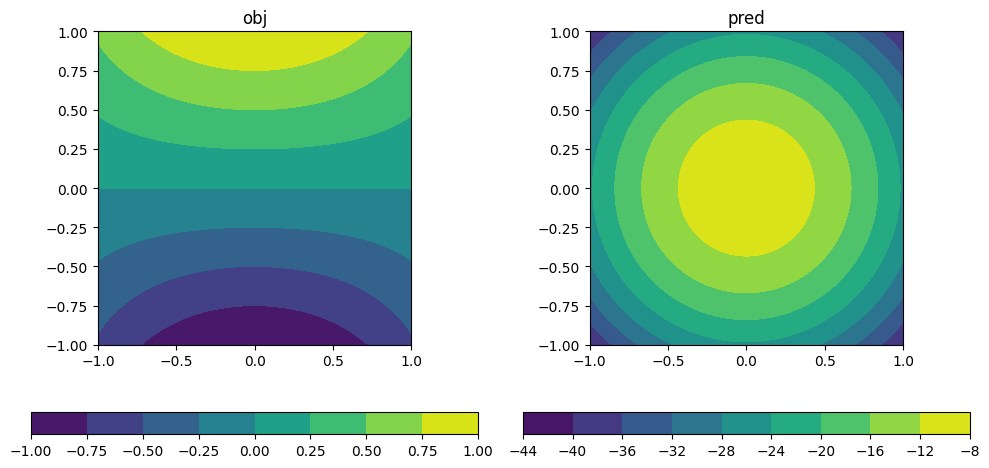

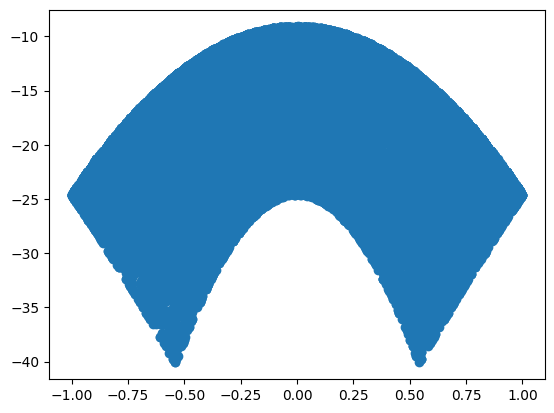

In [12]:
def init_params(layers, key):
  # Equisdi initialization
  Ws = []
  bs = []
  for i in range(len(layers) - 1):
    mid_point = layers[i + 1]//2
    c = jnp.linspace(-1, 1, mid_point+2)[1:-1]
    c2 = jnp.linspace(-1, 1, layers[i + 1]-mid_point+2)[1:-1]
    c = jnp.hstack([c, c2])
    W = np.ones((layers[i], layers[i + 1]))
    W[:,::2]*=-1
    W[0, mid_point:]=0#1e-2
    W[1, :mid_point]=0#1e-2
    b = -W.sum(0)*c

    Ws.append(W)  
    bs.append(b)
  return [Ws, bs]

layers = [2] + [64]*1 + [1]

params = init_params(layers, key)
L, Y_pred = forward_pass_multi(X, params, params[0][-1])
for i in range(L.shape[1]):
    plt.contour(*mesh, L[:,i].reshape(mesh[0].shape), levels=[0])
plt.axis("scaled")
plt.show()

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.title("obj")
plt.contourf(*mesh, Y.reshape(mesh[0].shape))
# plt.plot(X_train[:,0], X_train[:,1], "rx", ms=1)
plt.colorbar(orientation="horizontal")
plt.axis("scaled")
plt.subplot(122)
plt.title("pred")
plt.contourf(*mesh, Y_pred.reshape(mesh[0].shape))
# plt.plot(X_train[:,0], X_train[:,1], "rx", ms=1)
plt.colorbar(orientation="horizontal")
plt.axis("scaled")
plt.tight_layout()
plt.show()
plt.scatter(Y_train, Y_pred[train_samples])
plt.show()

424.7631
0.006613261


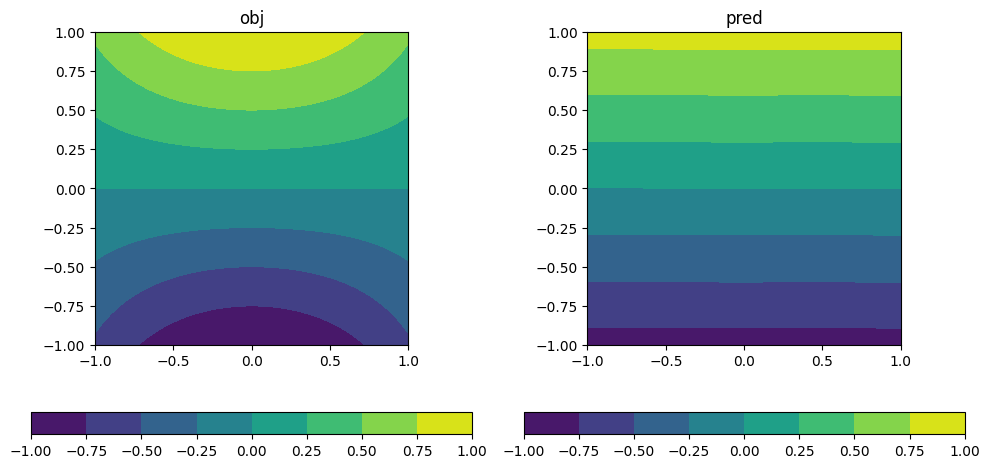

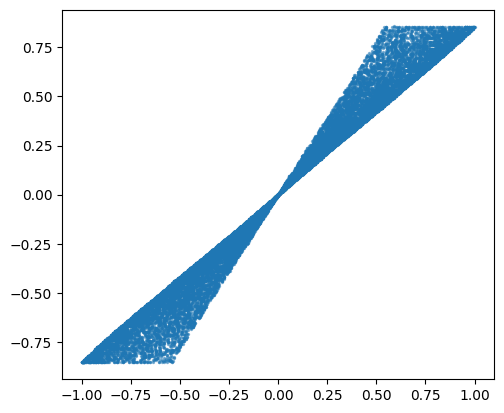

In [13]:
@jx.jit
def loss(params, s, X, Y, X_c):
    _, Y_pred = forward_pass_multi(X, params, s)
    MSE = jnp.mean((Y_pred-Y)**2)
    return MSE
X_c = jnp.array([[-1, 1],[1,1]])
print(loss(params, params[0][-1], X, Y, X_c))
s = trainer.leastsquares(loss, params, params[0][-1], X_train, Y_train, X_c)
print(loss(params, s, X, Y, X_c))
L, Y_pred = forward_pass_multi(X, params, s)

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.title("obj")
plt.contourf(*mesh, Y.reshape(mesh[0].shape))
# plt.plot(X_train[:,0], X_train[:,1], "rx", ms=1)
plt.colorbar(orientation="horizontal")
plt.axis("scaled")
plt.subplot(122)
plt.title("pred")
plt.contourf(*mesh, Y_pred.reshape(mesh[0].shape))
# plt.plot(X_train[:,0], X_train[:,1], "rx", ms=1)
plt.colorbar(orientation="horizontal")
plt.axis("scaled")
plt.tight_layout()
plt.show()

plt.scatter(Y_train, Y_pred[train_samples], s=2, alpha=0.5)
plt.axis("scaled")
plt.show()

it 9950, train loss = 1.736666e-04: 100%|████████████████████████████████████████| 10000/10000 [00:33<00:00, 296.48it/s]


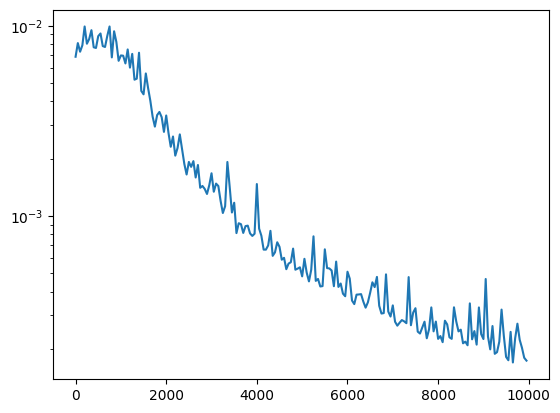

In [14]:
bsize = 512*2
bsize = 32*2
nIter = 10000
lr = 1e-4
stop_at = 5e-5

params = init_params(layers, key)
trainer = Training2(optimizers.adam, {"lr":lr}, mode="R")
opt_state = trainer.opt_init(params)
params, train_loss, val_loss = trainer.train(loss, 
        X_train, Y_train, X_c, opt_state, bsize=bsize, nIter = nIter, stop=stop_at)
plt.semilogy(np.arange(len(train_loss))*50, train_loss)
plt.show()

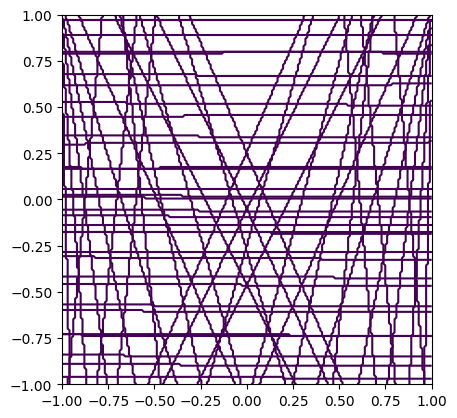

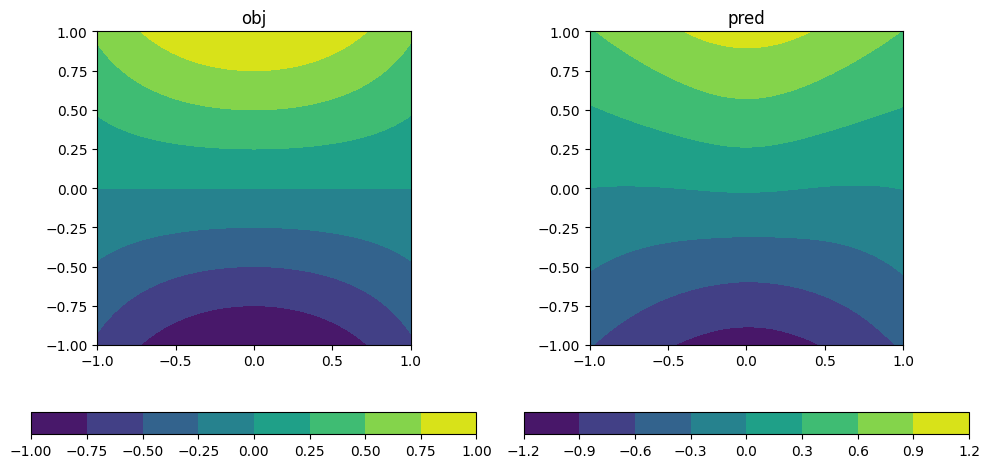

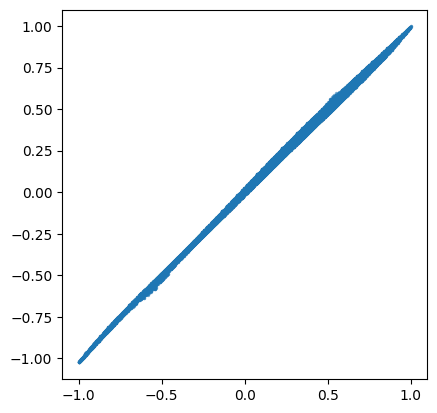

In [15]:
L, Y_pred = forward_pass_multi(X, params, params[0][-1])
for i in range(L.shape[1]):
    plt.contour(*mesh, L[:,i].reshape(mesh[0].shape), levels=[0])
plt.axis("scaled")
plt.show()
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.title("obj")
plt.contourf(*mesh, Y.reshape(mesh[0].shape))
# plt.plot(X_train[:,0], X_train[:,1], "rx", ms=1)
plt.colorbar(orientation="horizontal")
plt.axis("scaled")
plt.subplot(122)
plt.title("pred")
plt.contourf(*mesh, Y_pred.reshape(mesh[0].shape))
# plt.plot(X_train[:,0], X_train[:,1], "rx", ms=1)
plt.colorbar(orientation="horizontal")
plt.axis("scaled")
plt.tight_layout()
plt.show()
plt.scatter(Y_train, Y_pred[train_samples], s=2, alpha=0.5)
plt.axis("scaled")
plt.show()

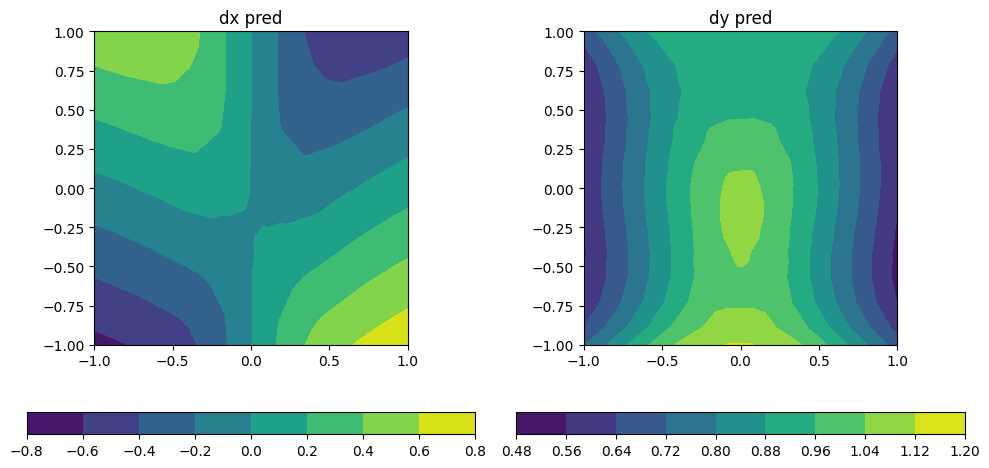

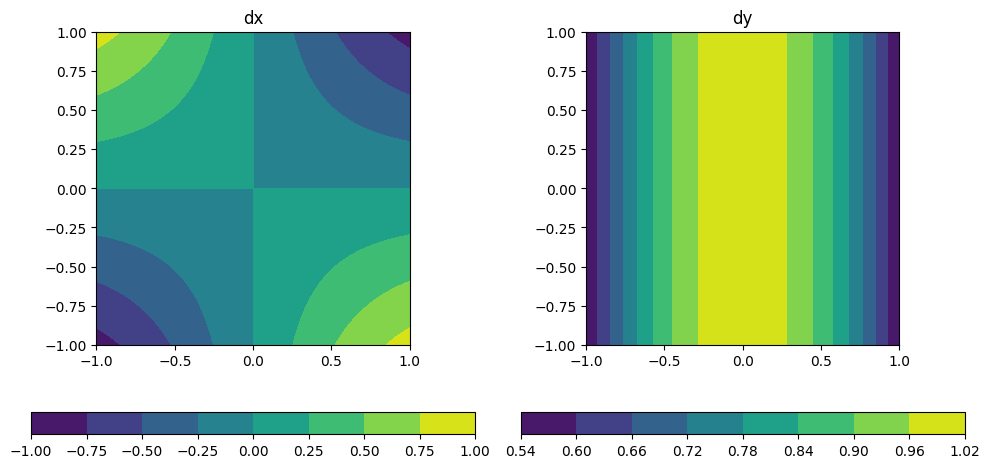

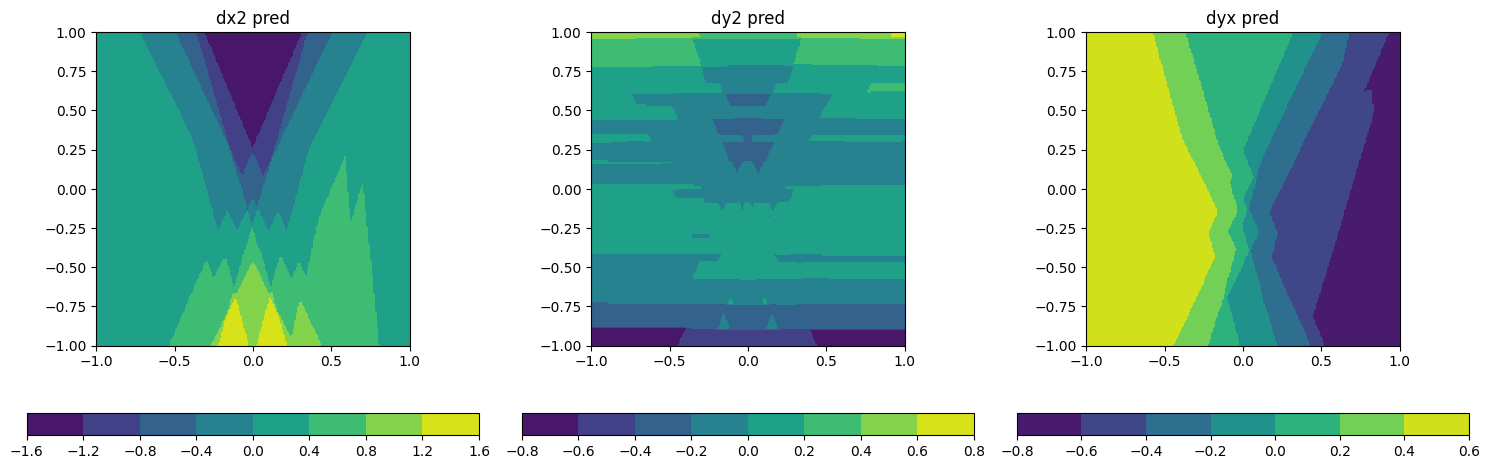

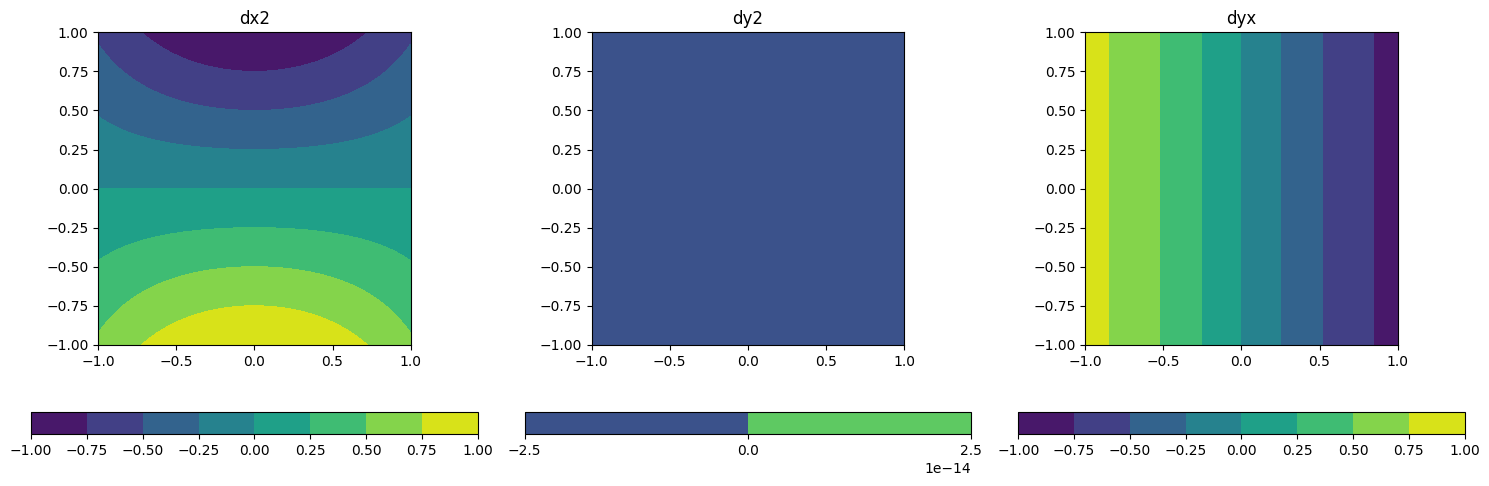

In [16]:
L, Y_pred = forward_pass_multi_grad(X, params, params[0][-1])
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.title("dx pred")
plt.contourf(*mesh, Y_pred[:,:,0].reshape(mesh[0].shape))
# plt.plot(X_train[:,0], X_train[:,1], "rx", ms=1)
plt.colorbar(orientation="horizontal")
plt.axis("scaled")
plt.subplot(122)
plt.title("dy pred")
plt.contourf(*mesh, Y_pred[:,:,1].reshape(mesh[0].shape))
# plt.plot(X_train[:,0], X_train[:,1], "rx", ms=1)
plt.colorbar(orientation="horizontal")
plt.axis("scaled")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.title("dx")
plt.contourf(*mesh, dYx.reshape(mesh[0].shape))
# plt.plot(X_train[:,0], X_train[:,1], "rx", ms=1)
plt.colorbar(orientation="horizontal")
plt.axis("scaled")
plt.subplot(122)
plt.title("dy")
plt.contourf(*mesh, dYy.reshape(mesh[0].shape))
# plt.plot(X_train[:,0], X_train[:,1], "rx", ms=1)
plt.colorbar(orientation="horizontal")
plt.axis("scaled")
plt.tight_layout()
plt.show()

L, Y_pred = forward_pass_multi_grad2(X, params, params[0][-1])
plt.figure(figsize=(15,5))
plt.subplot(131)
plt.title("dx2 pred")
plt.contourf(*mesh, Y_pred[:,:,0,0].reshape(mesh[0].shape))
# plt.plot(X_train[:,0], X_train[:,1], "rx", ms=1)
plt.colorbar(orientation="horizontal")
plt.axis("scaled")
plt.subplot(132)
plt.title("dy2 pred")
plt.contourf(*mesh, Y_pred[:,:,1,1].reshape(mesh[0].shape))
# plt.plot(X_train[:,0], X_train[:,1], "rx", ms=1)
plt.colorbar(orientation="horizontal")
plt.axis("scaled")
plt.subplot(133)
plt.title("dyx pred")
plt.contourf(*mesh, Y_pred[:,:,0,1].reshape(mesh[0].shape))
# plt.plot(X_train[:,0], X_train[:,1], "rx", ms=1)
plt.colorbar(orientation="horizontal")
plt.axis("scaled")
plt.tight_layout()
plt.show()

plt.figure(figsize=(15,5))
plt.subplot(131)
plt.title("dx2")
plt.contourf(*mesh, d2Yxx.reshape(mesh[0].shape))
# plt.plot(X_train[:,0], X_train[:,1], "rx", ms=1)
plt.colorbar(orientation="horizontal")
plt.axis("scaled")
plt.subplot(132)
plt.title("dy2")
plt.contourf(*mesh, d2Yyy.reshape(mesh[0].shape))
# plt.plot(X_train[:,0], X_train[:,1], "rx", ms=1)
plt.colorbar(orientation="horizontal")
plt.axis("scaled")
plt.subplot(133)
plt.title("dyx")
plt.contourf(*mesh, d2Yxy.reshape(mesh[0].shape))
# plt.plot(X_train[:,0], X_train[:,1], "rx", ms=1)
plt.colorbar(orientation="horizontal")
plt.axis("scaled")
plt.tight_layout()
plt.show()

(40000, 2) (40000, 1)


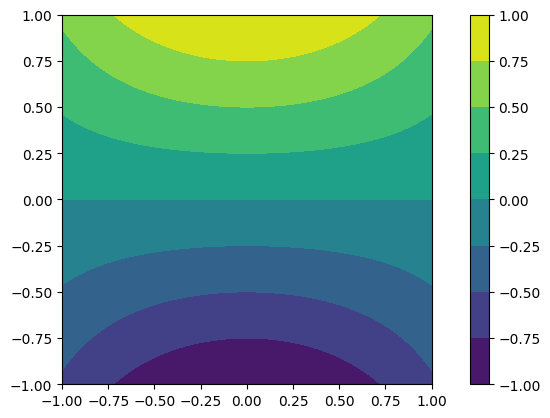

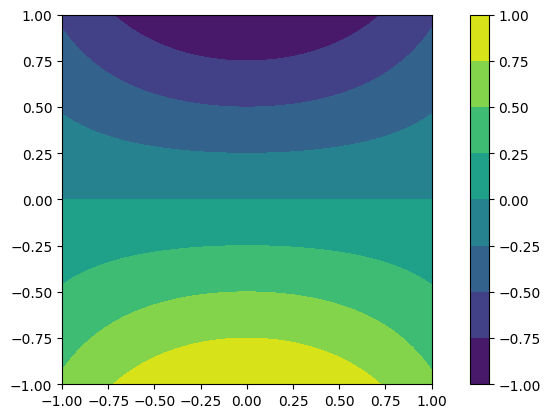

In [17]:
x = np.linspace(-1, 1, 200)
mesh = np.meshgrid(x, x)
X = np.c_[mesh[0].flatten(), mesh[1].flatten()]
# Y = np.cos(np.pi*X[:,0])*np.cos(np.pi*X[:,1])
Y = np.cos(X[:,0])*X[:,1]
# Y = (X[:,0]**2+X[:,1]**2)[:,None]
Y = Y[:,None]
dYx = -np.sin(X[:,0])*X[:,1]
dYy = np.cos(X[:,0])
d2Yxx = -np.cos(X[:,0])*X[:,1]
d2Yxy = -np.sin(X[:,0])
d2Yyy = 0*X[:,0]
d2Yyx = -np.sin(X[:,0])

print(X.shape, Y.shape)


plt.contourf(*mesh, Y.reshape(mesh[0].shape))
# plt.plot(X_train[:,0], X_train[:,1], "rx", ms=1)
plt.colorbar()
plt.axis("scaled")
plt.show()


plt.contourf(*mesh, (d2Yxx+d2Yyy).reshape(mesh[0].shape))
# plt.plot(X_train[:,0], X_train[:,1], "rx", ms=1)
plt.colorbar()
plt.axis("scaled")
plt.show()

it 9950, train loss = 9.228673e-02: 100%|████████████████████████████████████████| 10000/10000 [01:16<00:00, 130.93it/s]


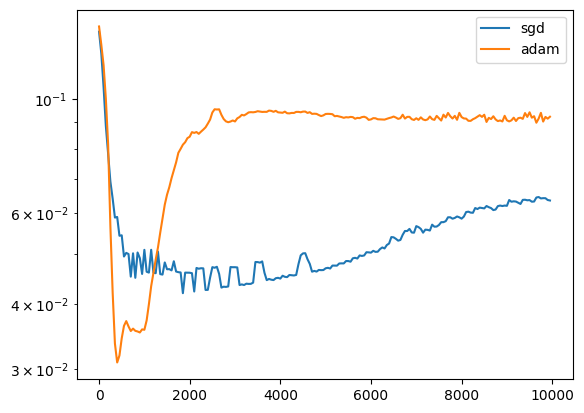

In [75]:
layers = [2] + [16]*1 + [1]
bsize = 512*4
# bsize = 32*2
nIter = 10000
lr = 1e-2
stop_at = 5e-5

X_c = np.c_[np.c_[x,x*0-1].T,np.c_[x,x*0+1].T, np.c_[x*0-1, x].T, np.c_[x*0+1, x].T].T
lmbi = 1
@jx.jit
def loss(params, s, X, Y, X_c):
    _, Y_pred = forward_pass_multi(X_c, params, s)
    bd = jnp.cos(X_c[:,0])*X_c[:,1]
    # _, Y_pred_g = forward_pass_multi_grad(X, params, s)
    _, Y_pred_g2 = forward_pass_multi_grad2(X, params, s)
    lapla = Y_pred_g2[:,0,0,0]+ Y_pred_g2[:,0,1,1]
    obj = -jnp.cos(X[:,0])*X[:,1]
    MSE =jnp.mean((lapla-obj)**2)*lmbi
    MSE+= jnp.mean((Y_pred-bd[:,None])**2)
    return MSE

params = init_params(layers, key)
# trainer = Training2(optimizers.adam, {"lr":lr}, mode="MC")
trainer = Training2(optimizers.sgd, {"lr":lr}, mode="MC")
opt_state = trainer.opt_init(params)
params, train_loss, val_loss = trainer.train(loss, 
        X_train, Y_train, X_c, opt_state, bsize=bsize, nIter = nIter, stop=stop_at)
plt.semilogy(np.arange(len(train_loss))*50, train_loss, label="sgd")

params = init_params(layers, key)
trainer = Training2(optimizers.adam, {"lr":lr*1e-1}, mode="MC")
# trainer = Training2(optimizers.sgd, {"lr":lr}, mode="MC")
opt_state = trainer.opt_init(params)
params, train_loss, val_loss = trainer.train(loss, 
        X_train, Y_train, X_c, opt_state, bsize=bsize, nIter = nIter, stop=stop_at)
plt.semilogy(np.arange(len(train_loss))*50, train_loss, label="adam")
plt.legend()
plt.show()

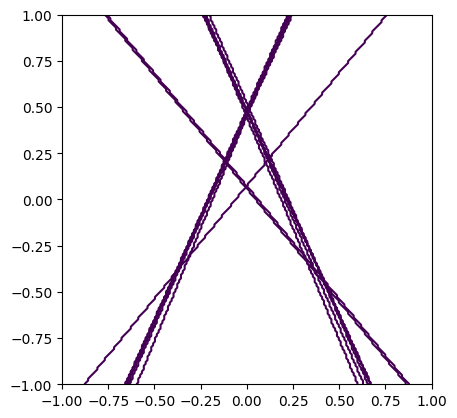

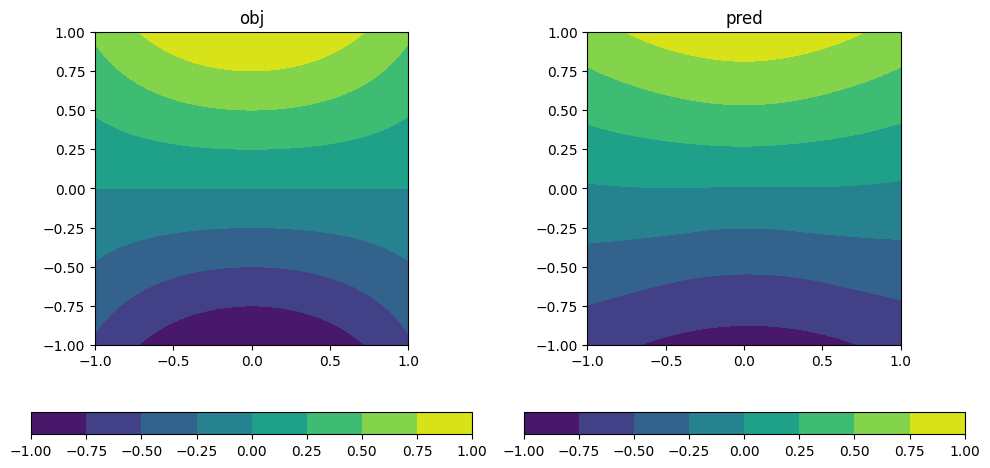

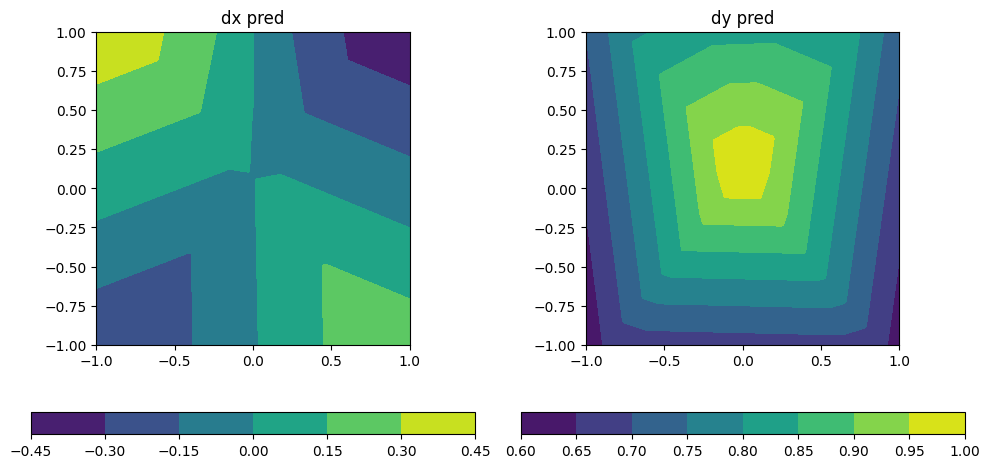

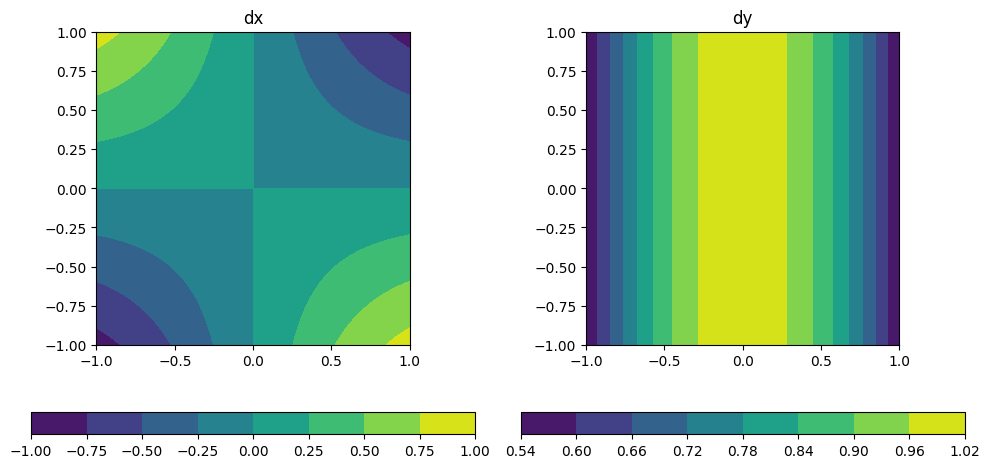

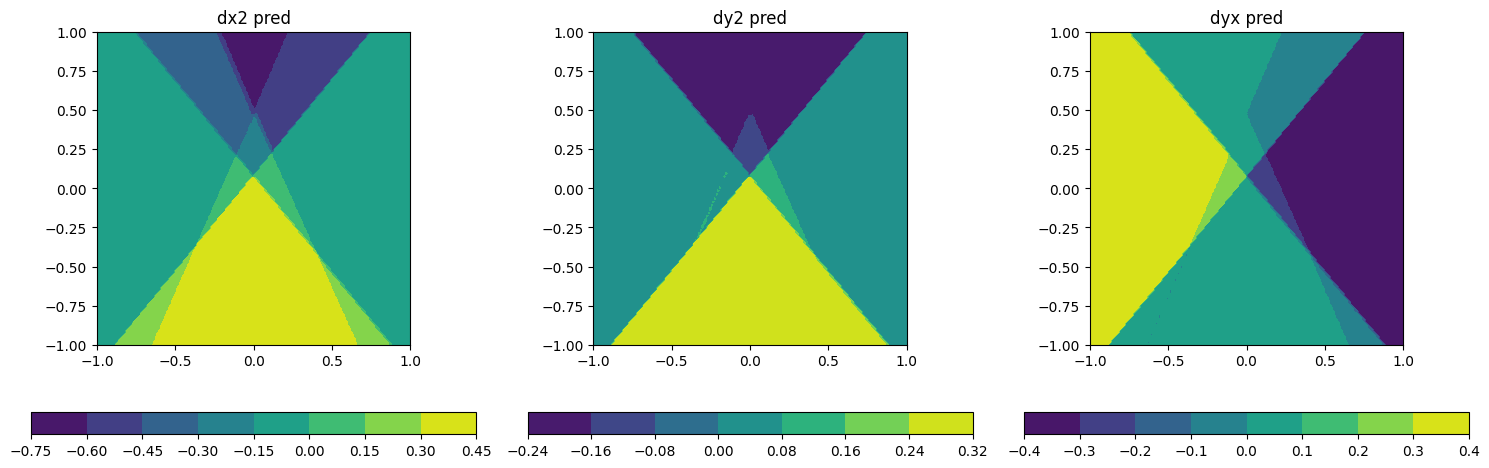

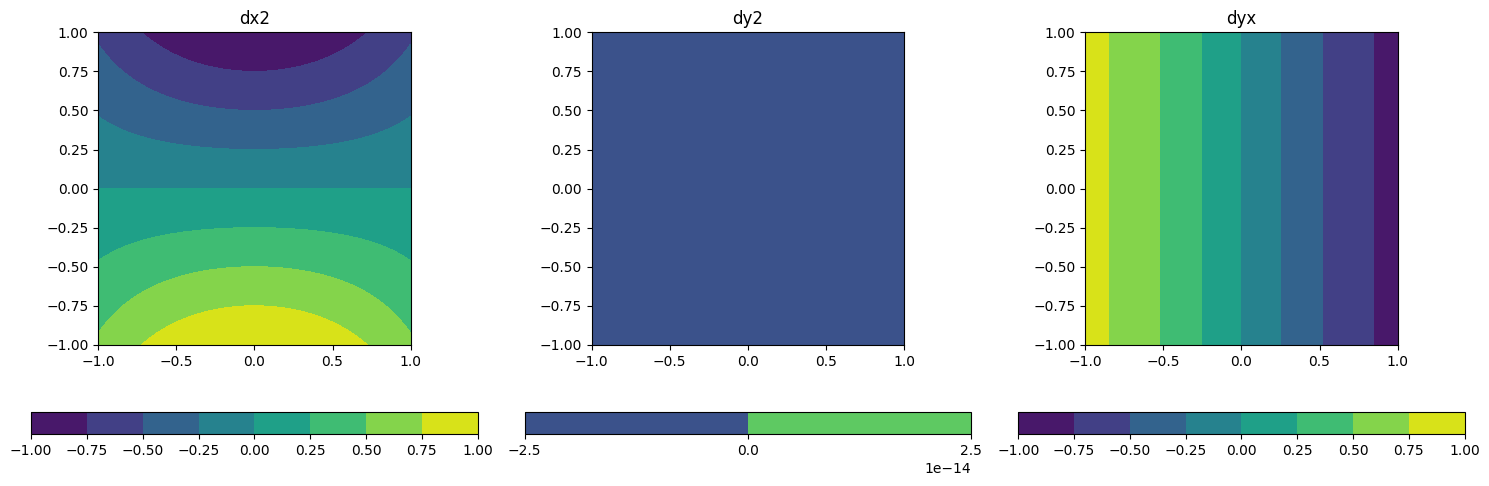

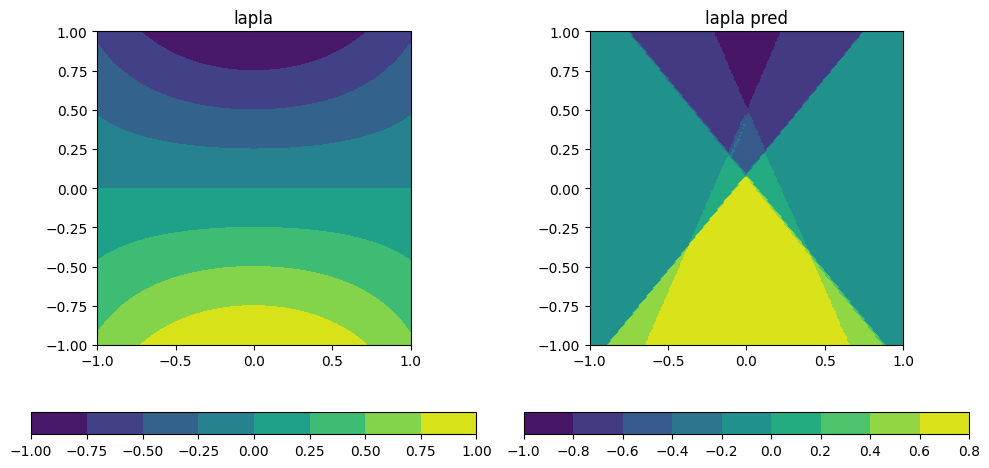

In [76]:
L, Y_pred = forward_pass_multi(X, params, params[0][-1])
for i in range(L.shape[1]):
    plt.contour(*mesh, L[:,i].reshape(mesh[0].shape), levels=[0])
plt.axis("scaled")
plt.show()
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.title("obj")
plt.contourf(*mesh, Y.reshape(mesh[0].shape))
# plt.plot(X_train[:,0], X_train[:,1], "rx", ms=1)
plt.colorbar(orientation="horizontal")
plt.axis("scaled")
plt.subplot(122)
plt.title("pred")
plt.contourf(*mesh, Y_pred.reshape(mesh[0].shape))
# plt.plot(X_train[:,0], X_train[:,1], "rx", ms=1)
plt.colorbar(orientation="horizontal")
plt.axis("scaled")
plt.tight_layout()
plt.show()
L, Y_pred = forward_pass_multi_grad(X, params, params[0][-1])
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.title("dx pred")
plt.contourf(*mesh, Y_pred[:,:,0].reshape(mesh[0].shape))
# plt.plot(X_train[:,0], X_train[:,1], "rx", ms=1)
plt.colorbar(orientation="horizontal")
plt.axis("scaled")
plt.subplot(122)
plt.title("dy pred")
plt.contourf(*mesh, Y_pred[:,:,1].reshape(mesh[0].shape))
# plt.plot(X_train[:,0], X_train[:,1], "rx", ms=1)
plt.colorbar(orientation="horizontal")
plt.axis("scaled")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.title("dx")
plt.contourf(*mesh, dYx.reshape(mesh[0].shape))
# plt.plot(X_train[:,0], X_train[:,1], "rx", ms=1)
plt.colorbar(orientation="horizontal")
plt.axis("scaled")
plt.subplot(122)
plt.title("dy")
plt.contourf(*mesh, dYy.reshape(mesh[0].shape))
# plt.plot(X_train[:,0], X_train[:,1], "rx", ms=1)
plt.colorbar(orientation="horizontal")
plt.axis("scaled")
plt.tight_layout()
plt.show()

L, Y_pred = forward_pass_multi_grad2(X, params, params[0][-1])
plt.figure(figsize=(15,5))
plt.subplot(131)
plt.title("dx2 pred")
plt.contourf(*mesh, Y_pred[:,:,0,0].reshape(mesh[0].shape))
# plt.plot(X_train[:,0], X_train[:,1], "rx", ms=1)
plt.colorbar(orientation="horizontal")
plt.axis("scaled")
plt.subplot(132)
plt.title("dy2 pred")
plt.contourf(*mesh, Y_pred[:,:,1,1].reshape(mesh[0].shape))
# plt.plot(X_train[:,0], X_train[:,1], "rx", ms=1)
plt.colorbar(orientation="horizontal")
plt.axis("scaled")
plt.subplot(133)
plt.title("dyx pred")
plt.contourf(*mesh, Y_pred[:,:,0,1].reshape(mesh[0].shape))
# plt.plot(X_train[:,0], X_train[:,1], "rx", ms=1)
plt.colorbar(orientation="horizontal")
plt.axis("scaled")
plt.tight_layout()
plt.show()

plt.figure(figsize=(15,5))
plt.subplot(131)
plt.title("dx2")
plt.contourf(*mesh, d2Yxx.reshape(mesh[0].shape))
# plt.plot(X_train[:,0], X_train[:,1], "rx", ms=1)
plt.colorbar(orientation="horizontal")
plt.axis("scaled")
plt.subplot(132)
plt.title("dy2")
plt.contourf(*mesh, d2Yyy.reshape(mesh[0].shape))
# plt.plot(X_train[:,0], X_train[:,1], "rx", ms=1)
plt.colorbar(orientation="horizontal")
plt.axis("scaled")
plt.subplot(133)
plt.title("dyx")
plt.contourf(*mesh, d2Yxy.reshape(mesh[0].shape))
# plt.plot(X_train[:,0], X_train[:,1], "rx", ms=1)
plt.colorbar(orientation="horizontal")
plt.axis("scaled")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.title("lapla")
plt.contourf(*mesh, d2Yxx.reshape(mesh[0].shape))
# plt.plot(X_train[:,0], X_train[:,1], "rx", ms=1)
plt.colorbar(orientation="horizontal")
plt.axis("scaled")
plt.subplot(122)
plt.title("lapla pred")
plt.contourf(*mesh, (Y_pred[:,:,0,0]+Y_pred[:,:,1,1]).reshape(mesh[0].shape))
# plt.plot(X_train[:,0], X_train[:,1], "rx", ms=1)
plt.colorbar(orientation="horizontal")
plt.axis("scaled")
plt.tight_layout()
plt.show()